In [1]:
%matplotlib inline
import random
import seaborn as sns
import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
from scipy.spatial import Voronoi, voronoi_plot_2d
markers = ['*','+','.','1']

def fmt_output(symbol,n,shape,data):
    #for printing vectors and matrices
    L, C = shape
    G = [data] if n==1 else data
    S =r''
    for i in range(n):
        S +=r'$'+symbol+('_'+str(i+1) if n!=1 else '')
        S +=r'=\begin{bmatrix}' if (L!=1 or C!=1) else r'=' 
        M = [G[i]] if L==1 else G[i]
        for l in range(L):
            S += r'{:.2f}'.format(M[l]) if C==1 else (r'{:.2f} '+ r'& {:.2f}'*(C-1)).format(*M[l])
            if(l!= L-1):
                S+=r'\\'
        S +='\end{bmatrix}, \quad $ 'if (L!=1 or C!=1) else r', \quad $ ' 
    display(Markdown(S))

In [2]:
# train and test datasets
train = pd.read_csv('Data/EMGaussian.data',sep=" ", names=["x","y"])
test  = pd.read_csv('Data/EMGaussian.test',sep=" ", names=["x","y"])
# number of Clusters 
K = 4

## 3.a.   K-means algorithm

In [3]:
class Kmeans:
    def __init__(self, data, K):
        self.K        = K
        self.data     = data 
        self.centers  = random.sample(list(data.values),K)                      # vector of centers mu_j
        self.previous = None                                                    # previous centers
        self.dist     = pd.DataFrame(index=data.index, columns=list(range(K)))  # matrix of distances ||x_i-mu_j||**2
        self.cluster  = None                                                    # index of closest center to x_i 
        self.iters    = 0                                                       # number of iterations
        self.distortion = None                                                  # the value of the distortion function J(z,mu)
    def update(self):
        self.previous = self.centers
        for j in range(self.K):
            self.dist[j] = (self.data - self.centers[j]).pow(2).sum(axis=1)
        self.cluster = self.dist.idxmin(axis=1)
        self.centers = [ np.array(self.data.loc[self.cluster == j].mean()) for j in range(self.K)]
       
    def fit(self):
        if self.iters == 0 : 
            self.update()
            self.iters += 1
        while sum(norm(self.centers[j]-self.previous[j]) for j in range(self.K))!=0:
            self.update()
            self.iters += 1
        self.distortion = self.dist.min(axis=1).sum()
    
    def predict(self,test):
        data = test.copy()
        dist = pd.DataFrame(index=data.index, columns=list(range(self.K)))
        for j in range(self.K):
            dist[j] = (data - self.centers[j]).pow(2).sum(1)
        data['cluster'] = dist.idxmin(axis=1)+1
        return data

In [4]:
# running K-means on the training data
model = Kmeans(train,K)
model.fit()
print('Iterations: '+ str(model.iters))
print('Centers:');fmt_output(r'\hat\mu',K,(2,1),model.centers)
# cluster predictions on the training and test data
clusters_train = model.predict(train)
clusters_test  = model.predict(test)
clusters_train['type'] = 'train'
clusters_test['type']  = 'test'
for_sns = pd.concat([clusters_train,clusters_test],axis=0)

Iterations: 8
Centers:


$\hat\mu_1=\begin{bmatrix}-2.24\\4.13\end{bmatrix}, \quad $ $\hat\mu_2=\begin{bmatrix}-3.82\\-4.27\end{bmatrix}, \quad $ $\hat\mu_3=\begin{bmatrix}3.80\\5.10\end{bmatrix}, \quad $ $\hat\mu_4=\begin{bmatrix}3.34\\-2.64\end{bmatrix}, \quad $ 

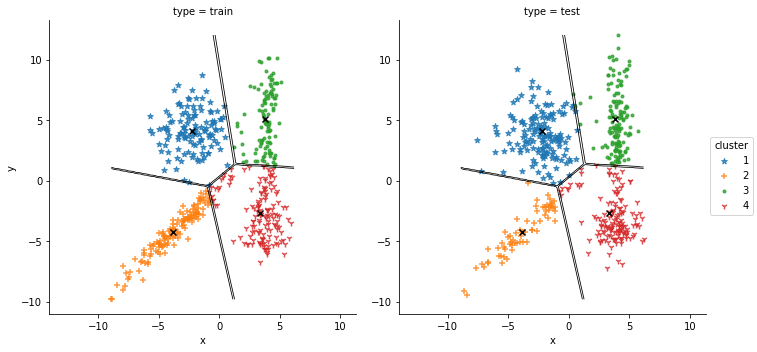

In [5]:
g = sns.lmplot(data=for_sns, x='x', y='y', col='type', hue='cluster',markers=markers[:K], fit_reg=False)
centers = list(zip(*model.centers))
xRange = (for_sns['x'].min(), for_sns['x'].max())
yRange = (for_sns['y'].min(), for_sns['y'].max())
x = np.linspace(*xRange, 200)
y = np.linspace(*yRange, 200)
x, y = np.meshgrid(x, y)
M = np.zeros((K,*x.shape))
for j in range(K):
    M[j] = (x - model.centers[j][0])**2+(y - model.centers[j][1])**2
M = np.sort(M, axis=0)
for ax in g.axes[0]:
    plt.gca().set_aspect('equal')
    ax.scatter(*centers, color='black', marker='x');
    ax.contour(x, y, M[1]-M[0], [1], colors='k', linewidths=0.8);

In [6]:
# trying multiple iterations
c_data = pd.DataFrame(columns=['x','y'])
N_inits = 10
distortions = []
iters_list  = []
for i in range(N_inits):
    model = Kmeans(train,K)
    model.fit()
    c_data = c_data.append(pd.DataFrame(model.centers,columns=['x','y']))
    distortions.append(model.distortion)
    iters_list.append(model.iters)

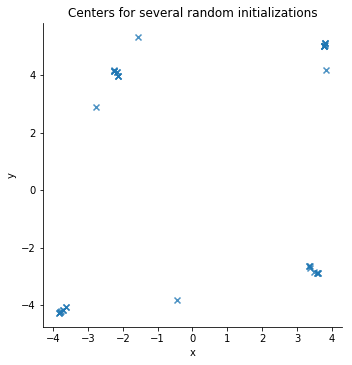

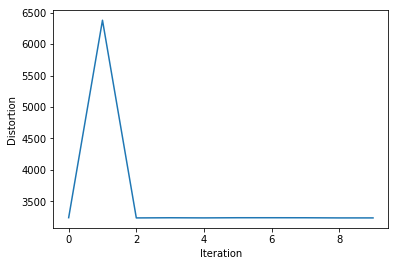

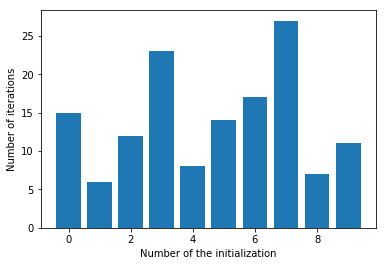

In [7]:
sns.lmplot(data=c_data, x='x', y='y', markers='x', fit_reg=False);
plt.gca().set_title('Centers for several random initializations')
plt.figure();plt.plot(distortions);plt.xlabel('Iteration');plt.ylabel('Distortion');
plt.figure();plt.bar(list(range(N_inits)),iters_list);
plt.xlabel('Number of the initialization');plt.ylabel('Number of iterations');

## 3.b.   EM algorithm, isotropic case

In [8]:
class EM_algorithm_iso:
    def __init__(self,data,K):
        model = Kmeans(data,K) 
        model.fit()
        self.K       = K
        self.d       = len(data.columns)
        self.data    = data
        self.tau_ji  = 1.0 - model.dist.gt(model.dist.min(axis=1),axis=0)   # matrix of tau_ji = P(z_i = j|x_i)
        self.p_j     = self.tau_ji.mean(axis=0)                             # vector of p_j = P(z=j)
        self.centers = model.centers              # vector of centers mu_j
        self.dist    = model.dist                 # matrix of distances ||x_i - mu_j||**2
        self.vars    = np.repeat(100.0,K)         # vector of variances for each matrix Sigma_j = var_j * I_2
        self.iters   = 0                          # number of iterations
        self.old_ll  = 0.0                        # old value of the log likelihood
        self.new_ll  = 0.0                        # new value of the log likelihood

    def E_step(self):
        self.tau_ji = self.p_j*np.exp(-0.5*self.dist/self.vars)/(2*np.pi*self.vars)
        self.tau_ji = self.tau_ji.div(self.tau_ji.sum(axis=1), axis=0)
        
    def M_step(self):
        self.p_j = self.tau_ji.mean(axis=0)
        for j in range(self.K):
            self.centers[j] = np.average(self.data, weights=self.tau_ji[j], axis=0)
            self.dist[j]    = (self.data-self.centers[j]).pow(2).sum(axis=1)
            self.vars[j]    = np.average(self.dist[j], weights=self.tau_ji[j], axis=0)/float(self.d)
            
    def update_ll(self):
        self.old_ll = self.new_ll
        p_xi = (self.p_j*np.exp(-0.5*self.dist/self.vars)/(2*np.pi*self.vars)).sum(axis=1)
        self.new_ll = np.sum(np.log(p_xi))
        return self.new_ll
        
    def update(self):
            self.E_step()
            self.M_step()
            self.update_ll() 
            
    def fit(self,tol=1e-6, max_iters=1000, verbose=False):
        if self.iters == 0 :
            self.update()
            self.iters += 1
            if verbose:
                print('Iteration: 01, log likelihood: {:.4f}'.format(self.new_ll))
        while(np.abs(self.new_ll-self.old_ll)>tol and self.iters<max_iters):
            self.update()
            self.iters += 1
            if verbose and self.iters%10 == 0 :
                print('Iteration: {:d}, log likelihood: {:.4f}'.format(self.iters, self.new_ll))
        if verbose:
            print('Last iteration: {:d}, log likelihood: {:.4f}'.format(self.iters, self.new_ll))
        
    def ll(self, data):
        dist = pd.DataFrame(index=data.index, columns=list(range(self.K)))
        for j in range(self.K):
            dist[j] = (data - self.centers[j]).pow(2).sum(1)
        p_xi = (self.p_j*np.exp(-0.5*dist/self.vars)/(2*np.pi*self.vars)).sum(axis=1)
        return np.sum(np.log(p_xi))
        
    def predict(self,test):
        data = test.copy()
        dist = pd.DataFrame(index=data.index, columns=list(range(self.K)))
        for j in range(self.K):
            dist[j] = (data - self.centers[j]).pow(2).sum(1)
        tau_ji  = self.p_j*np.exp(-0.5*dist/self.vars)/(2*np.pi*self.vars)  
        # here tau_ji not normalized since it's only used to find the maximum
        data['cluster'] = tau_ji.idxmax(axis=1)+1
        return data

In [9]:
# running isotropic EM on the training data
EM_iso = EM_algorithm_iso(train,K)
EM_iso.fit(tol=1e-6,verbose=True);
fmt_output(r'\hat\pi',K,(1,1),EM_iso.p_j)
fmt_output(r'\hat\mu',K,(2,1),EM_iso.centers)
fmt_output(r'\hat\sigma^2',K,(1,1),EM_iso.vars)
# cluster predictions on the training and test data
clusters_train = EM_iso.predict(train)
clusters_test  = EM_iso.predict(test)
clusters_train['type'] = 'train'
clusters_test['type']  = 'test'
for_sns = pd.concat([clusters_train,clusters_test],axis=0)

Iteration: 01, log likelihood: -2831.8837
Iteration: 10, log likelihood: -2779.8592
Iteration: 20, log likelihood: -2665.8295
Iteration: 30, log likelihood: -2658.7059
Iteration: 40, log likelihood: -2640.2553
Iteration: 50, log likelihood: -2639.6518
Iteration: 60, log likelihood: -2639.5815
Iteration: 70, log likelihood: -2639.5711
Iteration: 80, log likelihood: -2639.5696
Iteration: 90, log likelihood: -2639.5693
Iteration: 100, log likelihood: -2639.5693
Last iteration: 103, log likelihood: -2639.5693


$\hat\pi_1=0.37, \quad $ $\hat\pi_2=0.20, \quad $ $\hat\pi_3=0.17, \quad $ $\hat\pi_4=0.27, \quad $ 

$\hat\mu_1=\begin{bmatrix}2.61\\3.70\end{bmatrix}, \quad $ $\hat\mu_2=\begin{bmatrix}3.82\\-3.72\end{bmatrix}, \quad $ $\hat\mu_3=\begin{bmatrix}-2.61\\4.25\end{bmatrix}, \quad $ $\hat\mu_4=\begin{bmatrix}-3.66\\-4.08\end{bmatrix}, \quad $ 

$\hat\sigma^2_1=7.17, \quad $ $\hat\sigma^2_2=1.39, \quad $ $\hat\sigma^2_3=2.00, \quad $ $\hat\sigma^2_4=4.36, \quad $ 

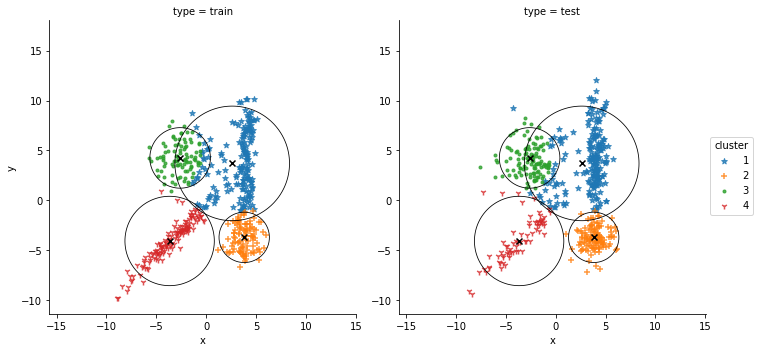

In [10]:
pct = 0.9 # percentage of distribution inside the circle
g = sns.lmplot(data=for_sns, x='x', y='y', col='type', hue='cluster',markers=markers[:K], fit_reg=False)
centers = list(zip(*EM_iso.centers))
for ax in g.axes[0]:
    plt.gca().set_aspect('equal')
    ax.scatter(*centers, color = 'black', marker ='x');
    xRange = (for_sns['x'].min(), 1.5*for_sns['x'].max())
    yRange = (for_sns['y'].min(), 1.5*for_sns['y'].max())
    x = np.linspace(*xRange, 100)
    y = np.linspace(*yRange, 100)
    x, y = np.meshgrid(x, y)
    for j in range(K):
        ax.contour(x, y, (x-EM_iso.centers[j][0])**2+(y-EM_iso.centers[j][1])**2,
                   [-2*EM_iso.vars[j]*np.log(1-pct)], colors='k', linewidths=0.8)

## 3.c.   EM algorithm, general case

In [11]:
class EM_algorithm:
    def __init__(self,data,K):
        model = Kmeans(data,K) 
        model.fit()
        self.K       = K
        self.data    = data
        self.tau_ji  = 1.0 - model.dist.gt(model.dist.min(axis=1),axis=0)
        self.p_j     = self.tau_ji.mean(axis=0) 
        self.centers = model.centers
        self.dist    = pd.DataFrame(index=data.index, columns=list(range(K)))
        self.sigmas  = [np.diag([10.0,10.0]) for j in range(K)]                # list of covariance matrices Sigma_j
        self.dets    = np.repeat(100.0,K)
        self.iters   = 0
        self.old_ll  = 0.0
        self.new_ll  = 0.0

    def E_step(self):
        for j in range(self.K):
            delta        = (self.data-self.centers[j]).values
            self.dist[j] = np.dot(delta,np.dot(np.linalg.inv(self.sigmas[j]),delta.T)).diagonal()
        self.tau_ji = self.p_j*np.exp(-0.5*self.dist)/(2*np.pi*np.sqrt(self.dets))
        self.tau_ji = self.tau_ji.div(self.tau_ji.sum(axis=1), axis=0)
        
    def M_step(self):
        self.p_j = self.tau_ji.mean(axis=0)
        for j in range(self.K):
            self.centers[j] = np.average(self.data, weights=self.tau_ji[j], axis=0)
            delta           = (self.data-self.centers[j]).values
            self.sigmas[j]  = np.dot(delta.T,self.tau_ji[j].values[:,None]*delta)/self.tau_ji[j].sum()
            self.dets[j]    = np.linalg.det(self.sigmas[j])
            
    def update_ll(self):
        self.old_ll = self.new_ll
        p_xi = (self.p_j*np.exp(-0.5*self.dist)/(2*np.pi*np.sqrt(self.dets))).sum(axis=1)
        self.new_ll = np.sum(np.log(p_xi))
        
    def update(self):
            self.E_step()
            self.M_step()
            self.update_ll() 
            
    def fit(self,tol=1e-6, max_iters=1000, verbose=False):
        if self.iters == 0 :
            self.update()
            self.iters += 1
            if verbose:
                print('Iteration: 01, log likelihood: {:.4f}'.format(self.new_ll))
        while(np.abs(self.new_ll-self.old_ll)>tol and self.iters<max_iters):
            self.update()
            self.iters += 1
            if verbose and self.iters%10 == 0 :
                print('Iteration: {:d}, log likelihood: {:.4f}'.format(self.iters, self.new_ll))
        if verbose:
            print('Last iteration: {:d}, log likelihood: {:.4f}'.format(self.iters, self.new_ll))

    def ll(self, data):
        dist = pd.DataFrame(index=data.index, columns=list(range(self.K)))
        for j in range(self.K):
            delta   = (data-self.centers[j]).values
            dist[j] = np.dot(delta,np.dot(np.linalg.inv(self.sigmas[j]),delta.T)).diagonal()
        p_xi = (self.p_j*np.exp(-0.5*dist)/(2*np.pi*np.sqrt(self.dets))).sum(axis=1)
        return np.sum(np.log(p_xi))
    
    def predict(self,test):
        data = test.copy()
        dist = pd.DataFrame(index=data.index, columns=list(range(self.K)))
        for j in range(self.K):
            delta   = (data-self.centers[j]).values
            dist[j] = np.dot(delta,np.dot(np.linalg.inv(self.sigmas[j]),delta.T)).diagonal()
        tau_ji  = self.p_j*np.exp(-0.5*dist)/(2*np.pi*np.sqrt(self.dets)) #proportional
        data['cluster'] = tau_ji.idxmax(axis=1)+1
        return data

In [12]:
# running general EM on the training data
EM = EM_algorithm(train,K)
EM.fit(tol=1e-6,verbose=True);
fmt_output(r'\hat\pi',K,(1,1),EM.p_j)
fmt_output(r'\hat\mu',K,(2,1),EM.centers)
fmt_output(r'\hat\Sigma',K,(2,2),EM.sigmas)
# cluster predictions on the training and test data
clusters_train = EM.predict(train)
clusters_test  = EM.predict(test)
clusters_train['type'] = 'train'
clusters_test['type']  = 'test'
for_sns = pd.concat([clusters_train,clusters_test],axis=0)

Iteration: 01, log likelihood: -2504.3848
Iteration: 10, log likelihood: -2329.9880
Iteration: 20, log likelihood: -2328.1881
Iteration: 30, log likelihood: -2327.7969
Iteration: 40, log likelihood: -2327.7300
Iteration: 50, log likelihood: -2327.7182
Iteration: 60, log likelihood: -2327.7161
Iteration: 70, log likelihood: -2327.7158
Iteration: 80, log likelihood: -2327.7157
Last iteration: 86, log likelihood: -2327.7157


$\hat\pi_1=0.31, \quad $ $\hat\pi_2=0.26, \quad $ $\hat\pi_3=0.25, \quad $ $\hat\pi_4=0.18, \quad $ 

$\hat\mu_1=\begin{bmatrix}-3.06\\-3.53\end{bmatrix}, \quad $ $\hat\mu_2=\begin{bmatrix}3.98\\3.77\end{bmatrix}, \quad $ $\hat\mu_3=\begin{bmatrix}-2.03\\4.17\end{bmatrix}, \quad $ $\hat\mu_4=\begin{bmatrix}3.80\\-3.80\end{bmatrix}, \quad $ 

$\hat\Sigma_1=\begin{bmatrix}6.24 & 6.05\\6.05 & 6.18\end{bmatrix}, \quad $ $\hat\Sigma_2=\begin{bmatrix}0.21 & 0.29\\0.29 & 12.24\end{bmatrix}, \quad $ $\hat\Sigma_3=\begin{bmatrix}2.90 & 0.21\\0.21 & 2.76\end{bmatrix}, \quad $ $\hat\Sigma_4=\begin{bmatrix}0.92 & 0.06\\0.06 & 1.87\end{bmatrix}, \quad $ 

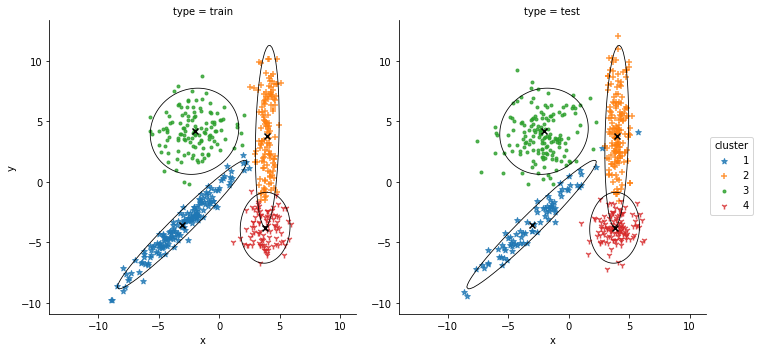

In [13]:
# percentage of distribution inside the ellipse
pct = 0.9
g = sns.lmplot(data=for_sns, x='x', y='y', col='type', hue='cluster',markers=markers[:K], fit_reg=False)
centers = list(zip(*EM.centers))
for ax in g.axes[0]:
    plt.gca().set_aspect('equal')
    ax.scatter(*centers, color='black', marker='x');
    xRange = (for_sns['x'].min(), for_sns['x'].max())
    yRange = (for_sns['y'].min(), for_sns['y'].max())
    x = np.linspace(*xRange, 100)
    y = np.linspace(*yRange, 100)
    x, y = np.meshgrid(x, y)
    for j in range(K):
        Inv = np.linalg.inv(EM.sigmas[j])
        a, b, c = Inv[0][0], Inv[1][0]+ Inv[0][1], Inv[1][1]
        ax.contour(x, y, a*(x-EM.centers[j][0])**2 + b*(x-EM.centers[j][0])*(y-EM.centers[j][1])+c*(y-EM.centers[j][1])**2
                   ,[-2*np.log(1-pct)], colors = 'k', linewidths=0.8)

In [14]:
# Comparing log likelihoods:
print('Isotropic EM:')
print('   - Training set: {:.3f}'.format(EM_iso.ll(train)))
print('   - Test set:     {:.3f}'.format(EM_iso.ll(test)))
print('General EM:')
print('   - Training set: {:.3f}'.format(EM.ll(train)))
print('   - Test set:     {:.3f}'.format(EM.ll(test)))

Isotropic EM:
   - Training set: -2639.569
   - Test set:     -2614.603
General EM:
   - Training set: -2327.716
   - Test set:     -2408.978
